In [180]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import pylab
import numpy as np
import matplotlib.pyplot as plt


<div class = "alert alert-block alert-info"

Выгрузим нужные данные из ClickHouse и проанализируем их в python. 
     

Датасет содержит информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

<div class = "alert alert-block alert-info"
<div>
Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings

In [6]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [10]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT COUNT(*)
    
    FROM ldn_listings
    
        
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count()
0,85207


<div class = "alert alert-block alert-info"
<div>
Выгрузиv из таблицы данные о цене в зависимости от типа жилья.

Сделаем лимит в 1000 строк

Для удобства из данных избавимся от запятых и знака $

Так же по сгрупированным данным посчитаем 75-й процентиль

In [18]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


In [22]:
df.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

<div class = "alert alert-block alert-info"
<div>

К данным о цене и типе комнаты дополнительно выгрузим данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.


Для начала сгрупируем наши данные и сделаем агрегацию и посчитаем среденее для цены и рейтинга и далее построим график

Выгрузим доп. данные для работы

In [45]:
query = """
SELECT id,
       room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
       toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM ldn_listings
WHERE review_scores_rating is not NULL
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df.head()

,id,room_type,price,review_scores_rating
0,13913,Private room,65.0,97.0
1,15400,Entire home/apt,100.0,96.0
2,17402,Entire home/apt,300.0,94.0
3,25023,Entire home/apt,65.0,93.0
4,25123,Private room,29.0,96.0


Выполним групировку и посчитаем средние

In [52]:
df_mean = df.groupby('room_type',as_index=False) \
    .agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
df_mean.head()

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


Строим график с помощью библиотеки seaborn

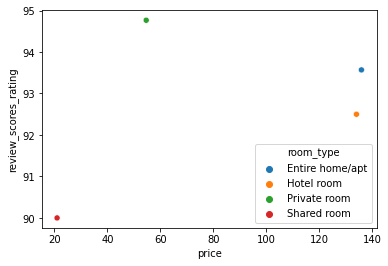

In [53]:
sns.scatterplot(data=df_mean, x="price", y="review_scores_rating", hue="room_type")

<div class = "alert alert-block alert-info"
<div>
Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузим только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработаем столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведем их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


2. Используем методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

в качестве ответа будет информация сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [111]:
query = """
SELECT DISTINCT host_id as uniq_host,
       host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df1 = ph.read_clickhouse(query, connection=connection_default)
df1.head()

,uniq_host,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


Чтобы привести к настоящему списку исползуем лямбду функции.
Так же будем использовать метод explode -  в Pandas предназначен для преобразования столбцов с вложенными списками или списками словарей в отдельные строки, копируя при этом значения остальных столбцов. Это позволяет упростить структуру данных для дальнейшего анализа.

In [112]:
df1.host_verifications = df1.host_verifications.apply(lambda x: x.strip(']').strip('[').replace('\'', '').split(', '))
df1 = df1.explode('host_verifications')
df1.head()

,uniq_host,host_verifications
0,54730,email
0,54730,phone
0,54730,facebook
0,54730,reviews
0,54730,offline_government_id


In [113]:
df1.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Ответ: 27

<div class = "alert alert-block alert-info"
<div>
Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовем experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

<div class = "alert alert-block alert-info"
<div>
Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [123]:
query = """
SELECT COUNT(experiences_offered) AS experiences_count,
       neighbourhood_cleansed,
       experiences_offered
       
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed,
         experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection_default)
df.head()

,experiences_count,neighbourhood_cleansed,experiences_offered
0,61,Hackney,family
1,58,Tower Hamlets,business
2,50,Westminster,business
3,49,Hackney,social
4,48,Hammersmith and Fulham,business


In [140]:
pivot_table = pd.pivot_table(df,
                            index = ["neighbourhood_cleansed"],
                            columns = ["experiences_offered"],
                            values = ["experiences_count"])
pivot_table.head()

experiences_count                       
experiences_offered             business family romantic social
neighbourhood_cleansed                                         
Barking and Dagenham                 NaN    NaN      NaN    2.0
Barnet                               7.0    7.0      3.0    5.0
Bexley                               1.0    NaN      NaN    NaN
Brent                                9.0   21.0      5.0    6.0
Bromley                              3.0    2.0      NaN    4.0

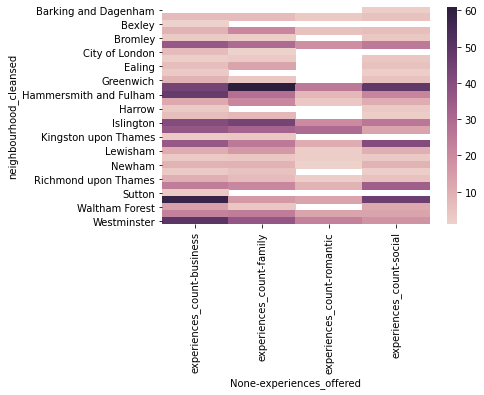

In [142]:
sns.heatmap(pivot_table,
           cmap=sns.cubehelix_palette(as_cmap=True))

<div class = "alert alert-block alert-info"
<div>
Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Для этого понадобятся следующие столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Пример части результирующей таблицы:



<div class = "alert alert-block alert-info"
<div>

Далее построим два графика, используя distplot из библиотеки seaborn:

На первом отобразим исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [182]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
       
FROM ldn_listings
WHERE experiences_offered != 'none'


"""
df = ph.read_clickhouse(query, connection=connection_default)
df.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


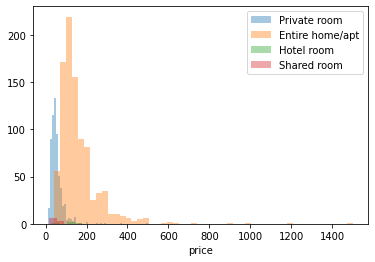

In [183]:
sns.distplot(df.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df.query("room_type=='Shared room'").price, kde=False, label='Shared room')

plt.legend()
plt.show()

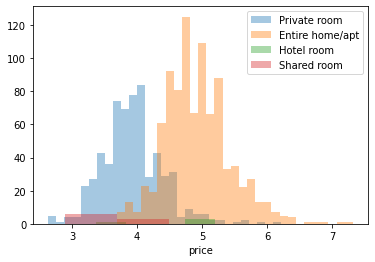

In [184]:
sns.distplot(np.log(df.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [201]:
query = """
SELECT room_type,
       toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
       first_review
       
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000


"""
df_1 = ph.read_clickhouse(query, connection=connection_default)
df_1.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


С помощью lambda-функции извлечем из колонки 'first_review' только год

И далее выполним следующие задания

In [202]:
df_1.first_review = df_1.first_review.apply(lambda x: x[:4])
df_1.head()

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010


In [208]:
avg_price = df_1.groupby(['room_type', 'first_review'], as_index=False)\
    .agg({'price' : 'mean'})
avg_price.head()

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328


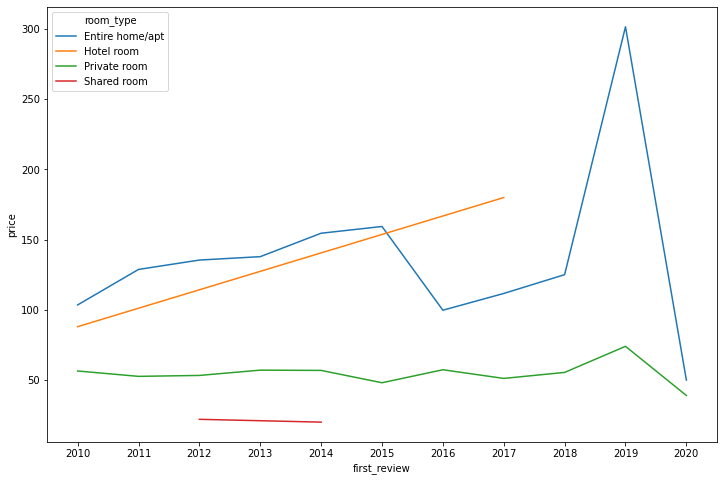

In [209]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=avg_price)